In [33]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from tqdm import tqdm
from sklearn import preprocessing, pipeline, linear_model, impute, model_selection
import seaborn as sns

from typing import Optional, Iterable

# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

### Join data, combine countries

In [3]:
country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [4]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

### LinReg - possible feature combinations

In [5]:
### TRAINING
lags_default = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
alternate_lags_default = {
    "value": [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
}

model_names = [
    "bench-rw",
    "bench-rw-realistic",
    "19",
    "ar",
    "ar+19",
]

feature_combinations = [
    ["value"],
    ["value"],
    ["19"],
    ["value"],
    ["value", "19"],
]

lags = [
    [1],
    [5],
    lags_default,
    lags_default,
    lags_default,
]

alternate_lags = [
    {},
    {},
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
]

use_linear_dummy = [True, True, False, False, False]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__positive": [True, False],
}

for i, name in enumerate(tqdm(model_names)):

    labeled = eumf_pipeline.prepare_data(
        panel_comb,
        columns=feature_combinations[i],
        lags=lags[i],
        alternate_lags=alternate_lags[i],
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled, delta = 12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if use_linear_dummy[i]:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(
            train_stacked, features=[feature_combinations[i][0] + "_" + str(lags[i][0])]
        )
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=linear_model.LinearRegression(),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_rmse,
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


In [14]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()

,linearregression__fit_intercept,linearregression__positive
19,True,True
ar,True,False
ar+19,True,False


In [6]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                     mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
bench-rw             0.007   1.566e-03  5.538e-04    0.011    9.244e-04  3.268e-04  -0.107   0.015  0.005   -0.143   0.024  0.009           0.021          0.392  0.139     0.145    0.471  0.167      0.030      0.062  0.022
bench-rw-realistic   0.005   4.449e-04  1.573e-04    0.009    3.833e-04  1.355e-04  -0.127   0.030  0.011   -0.172   0.046  0.016          -0.251          0.311  0.110    -0.085    0.441  0.156      0.011      0.051  0.018
19                   0.031   4.116e-03  1.455e-03    0.023    2.875e-03  1.016e-03  -0.110   0.032  0.011   -0.158   0.056  0.020           0.013          0.264  0.093     0.144    0.335  0.118      0.027      0.044  0.016
ar                   0.102   5.112e-02  1.808e-02    0.026    1.425e-02  5.040e-03  -0.104   0.033  0.012   -0.145   0.054  0.019           0.222          0.132  0.047     0.300    0.203  0.072      0.034      0.042  0.015
ar+19                0.081   4.304e-02  1.522e-02    0.031    7.524e-03  2.660e-03  -0.097   0.028  0.010   -0.138   0.051  0.018           0.250          0.168  0.059     0.359    0.205  0.073      0.040      0.047  0.017

In [7]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations)

,mae,rmse,explained_variance,r2_mod,delta_mae
['value'],-0.108,-0.158,0.582,0.618,0.055
['19'],-0.123,-0.204,0.336,0.366,0.040
"['value', '19']",-0.099,-0.140,0.667,0.700,0.065


#### Performance by year (CV+test)

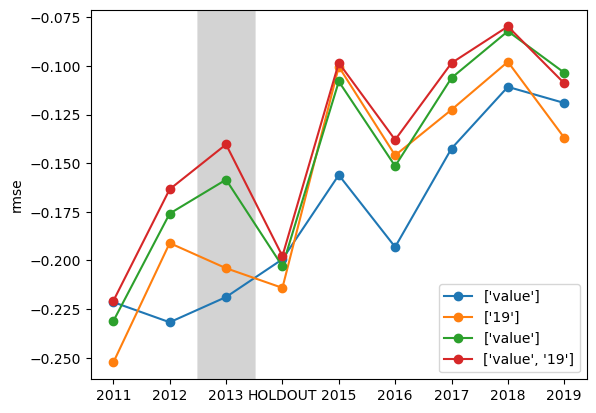

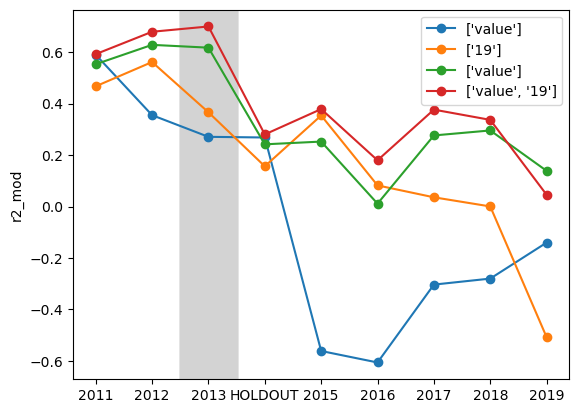

In [15]:
indices = [1, 2, -2, -1]
metrics = ["rmse", "r2_mod"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=feature_combinations,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=2,
    )
    plt.show()


#### Performance by country

test scores

In [30]:
i = model_names.index("ar+19")


In [31]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
IT,0.050,0.058,0.533,0.929,1.548e-01
HR,0.304,0.353,0.417,0.819,3.857e-01
RO,0.163,0.206,-0.637,0.693,1.923e-01
CZ+SK,0.059,0.069,0.289,0.621,2.959e-02
PT,0.120,0.161,-0.187,0.563,8.155e-02
AT+CH,0.052,0.063,0.237,0.502,2.447e-02
LV+LT+EE,0.071,0.089,-0.451,0.472,3.597e-02
SE+FI+DK,0.080,0.094,0.477,0.457,3.551e-02
GR,0.068,0.076,-0.767,0.425,1.752e-02
BG,0.191,0.223,-0.666,0.419,8.502e-02


CV scores

In [38]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0)
display(cv_scores_c_agg.sort_values(by=("delta_mae", "mean"), ascending=False))


CV scores per country:


mae                  rmse                explained_variance               r2_mod               delta_mae              
          mean   std    sem    mean   std    sem          mean         std    sem    mean   std    sem      mean    std    sem  
ES        0.090  0.036  0.013  0.111  0.043  0.015       -0.180        0.553  0.196  0.428  0.671  0.237    0.113   0.132  0.047
GR        0.101  0.033  0.012  0.129  0.047  0.017       -0.117        0.803  0.284  0.149  0.588  0.208    0.098   0.190  0.067
IT        0.058  0.018  0.006  0.071  0.024  0.008        0.261        0.378  0.133  0.580  0.346  0.122    0.092   0.115  0.041
PT        0.097  0.029  0.010  0.123  0.035  0.012       -0.185        0.554  0.196  0.463  0.281  0.099    0.066   0.078  0.028
RO        0.077  0.024  0.009  0.094  0.027  0.010        0.085        0.273  0.096  0.343  0.590  0.209    0.055   0.069  0.024
HU        0.109  0.064  0.022  0.131  0.069  0.024       -0.229        1.135  0.401  0.382  0.320  0.113    0.051   0.043  0.015
HR        0.154  0.150  0.053  0.188  0.197  0.070        0.402        0.244  0.086  0.403  0.270  0.095    0.045   0.050  0.018
PL        0.097  0.051  0.018  0.120  0.066  0.023        0.210        0.386  0.136  0.389  0.252  0.089    0.040   0.055  0.020
SI        0.228  0.148  0.052  0.272  0.171  0.061       -0.585        0.739  0.261 -0.021  0.659  0.233    0.037   0.089  0.031
BG        0.071  0.016  0.006  0.087  0.021  0.008       -0.208        0.532  0.188 -0.048  0.685  0.242    0.028   0.076  0.027
CZ+SK     0.096  0.055  0.019  0.117  0.067  0.024        0.167        0.231  0.082  0.170  0.375  0.132    0.027   0.044  0.016
IE        0.105  0.023  0.008  0.129  0.027  0.009        0.048        0.160  0.056  0.217  0.291  0.103    0.027   0.061  0.022
LV+LT+EE  0.108  0.064  0.023  0.133  0.079  0.028       -0.039        0.333  0.118  0.092  0.436  0.154    0.025   0.066  0.023
GB        0.071  0.033  0.012  0.090  0.037  0.013       -0.157        0.402  0.142  0.086  0.527  0.186    0.008   0.029  0.010
FR        0.061  0.010  0.004  0.077  0.018  0.006       -0.209        0.786  0.278 -0.162  1.007  0.356    0.006   0.013  0.005
SE+FI+DK  0.080  0.024  0.008  0.099  0.030  0.011       -0.143        0.384  0.136 -0.011  0.429  0.152    0.004   0.019  0.007
BE+NL+LU  0.071  0.017  0.006  0.091  0.020  0.007       -0.123        0.225  0.080 -0.065  0.364  0.129    0.003   0.016  0.006
AT+CH     0.074  0.035  0.012  0.098  0.059  0.021       -0.082        0.413  0.146  0.073  0.354  0.125    0.003   0.010  0.004

plot RMSE absolute

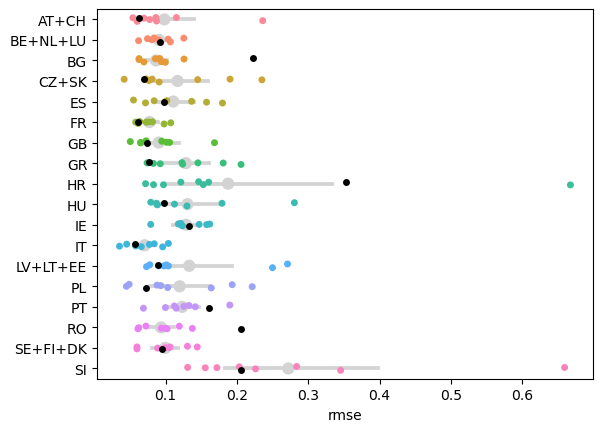

In [39]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

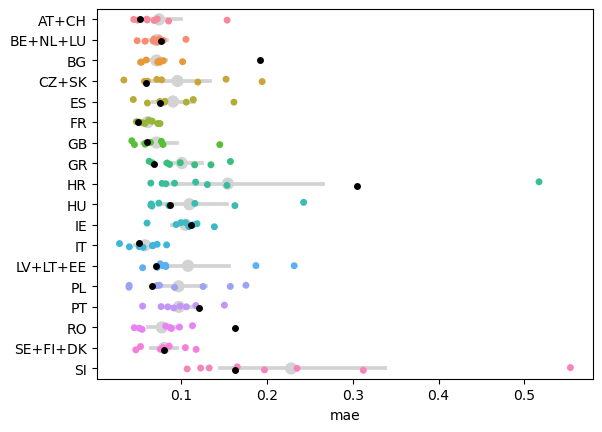

In [40]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

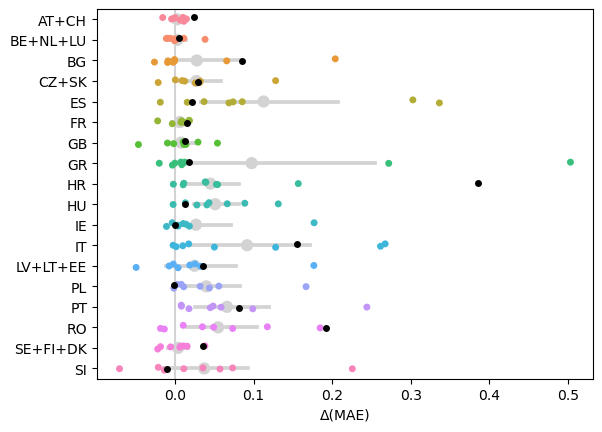

In [41]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### How important is Google Trends for each country? (diff KW19 vs no KW19)


##### without own lags

In [46]:
i1 = model_names.index("ar+19")
i2 = model_names.index("ar")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0)

cv_diff_agg["mae"].round(3).sort_values("mean", ascending=False)

,mean,std,sem
GR,0.034,0.058,0.021
ES,0.022,0.046,0.016
PL,0.018,0.033,0.012
IT,0.017,0.018,0.006
CZ+SK,0.015,0.022,0.008
PT,0.014,0.011,0.004
IE,0.011,0.011,0.004
HR,0.010,0.030,0.010
AT+CH,0.008,0.011,0.004
FR,0.004,0.007,0.002


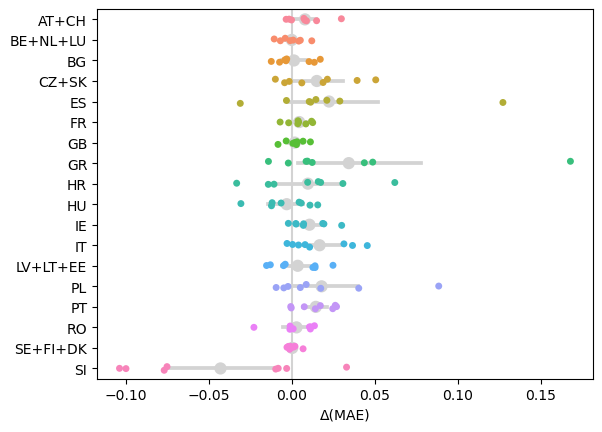

In [47]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
# sns.boxenplot(
#     data=cv_diff.reset_index(),
#     y="level_0",
#     x="mae",
#     # linestyles="",
#     # color="lightgrey",
#     # linewidth=0.0
# )
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


##### diff KW19 vs no KW19 (with value)


In [24]:
i1, i2 = 4, 3
reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_random)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0, use_quantiles=False)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_random)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0, use_quantiles=False)

cv_diff = cv_scores_c_agg1.xs("mean", level=1, axis=1) - cv_scores_c_agg2.xs(
    "mean", level=1, axis=1
)

cv_diff["mae"].round(3).sort_values(ascending=False)

GR          0.021
ES          0.018
IT          0.017
PT          0.016
PL          0.014
CZ+SK       0.012
AT+CH       0.008
HR          0.006
IE          0.006
FR          0.005
RO          0.004
BG          0.003
GB          0.003
HU         -0.000
LV+LT+EE    0.000
BE+NL+LU   -0.001
SE+FI+DK   -0.001
SI         -0.054
Name: mae, dtype: float64

#### coefficients (standardized)

In [27]:
reg = tuners[4].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].coef_, index=features_names_out).sort_values(
    ascending=False
)

value_5             5.138e-02
value_6             4.980e-02
value_17            2.212e-02
19_4                2.187e-02
19_2                2.024e-02
19_14               2.018e-02
19_1                1.744e-02
19_15               1.619e-02
19_3                1.588e-02
19_5                1.291e-02
value_9             1.251e-02
19_12               1.104e-02
19_8                1.049e-02
value_7             1.026e-02
value_16            1.001e-02
value_18            9.757e-03
value_13            9.209e-03
country_SI          8.607e-03
19_17               8.086e-03
19_16               7.704e-03
country_IT          5.853e-03
19_18               5.080e-03
country_RO          5.075e-03
19_13               3.847e-03
19_6                3.599e-03
19_9                3.453e-03
country_GB          2.882e-03
19_11               2.845e-03
country_HR          2.758e-03
country_ES          2.601e-03
value_14            2.361e-03
country_IE          1.888e-03
value_10            5.796e-04
country_BE

#### Plot prediction (all features)

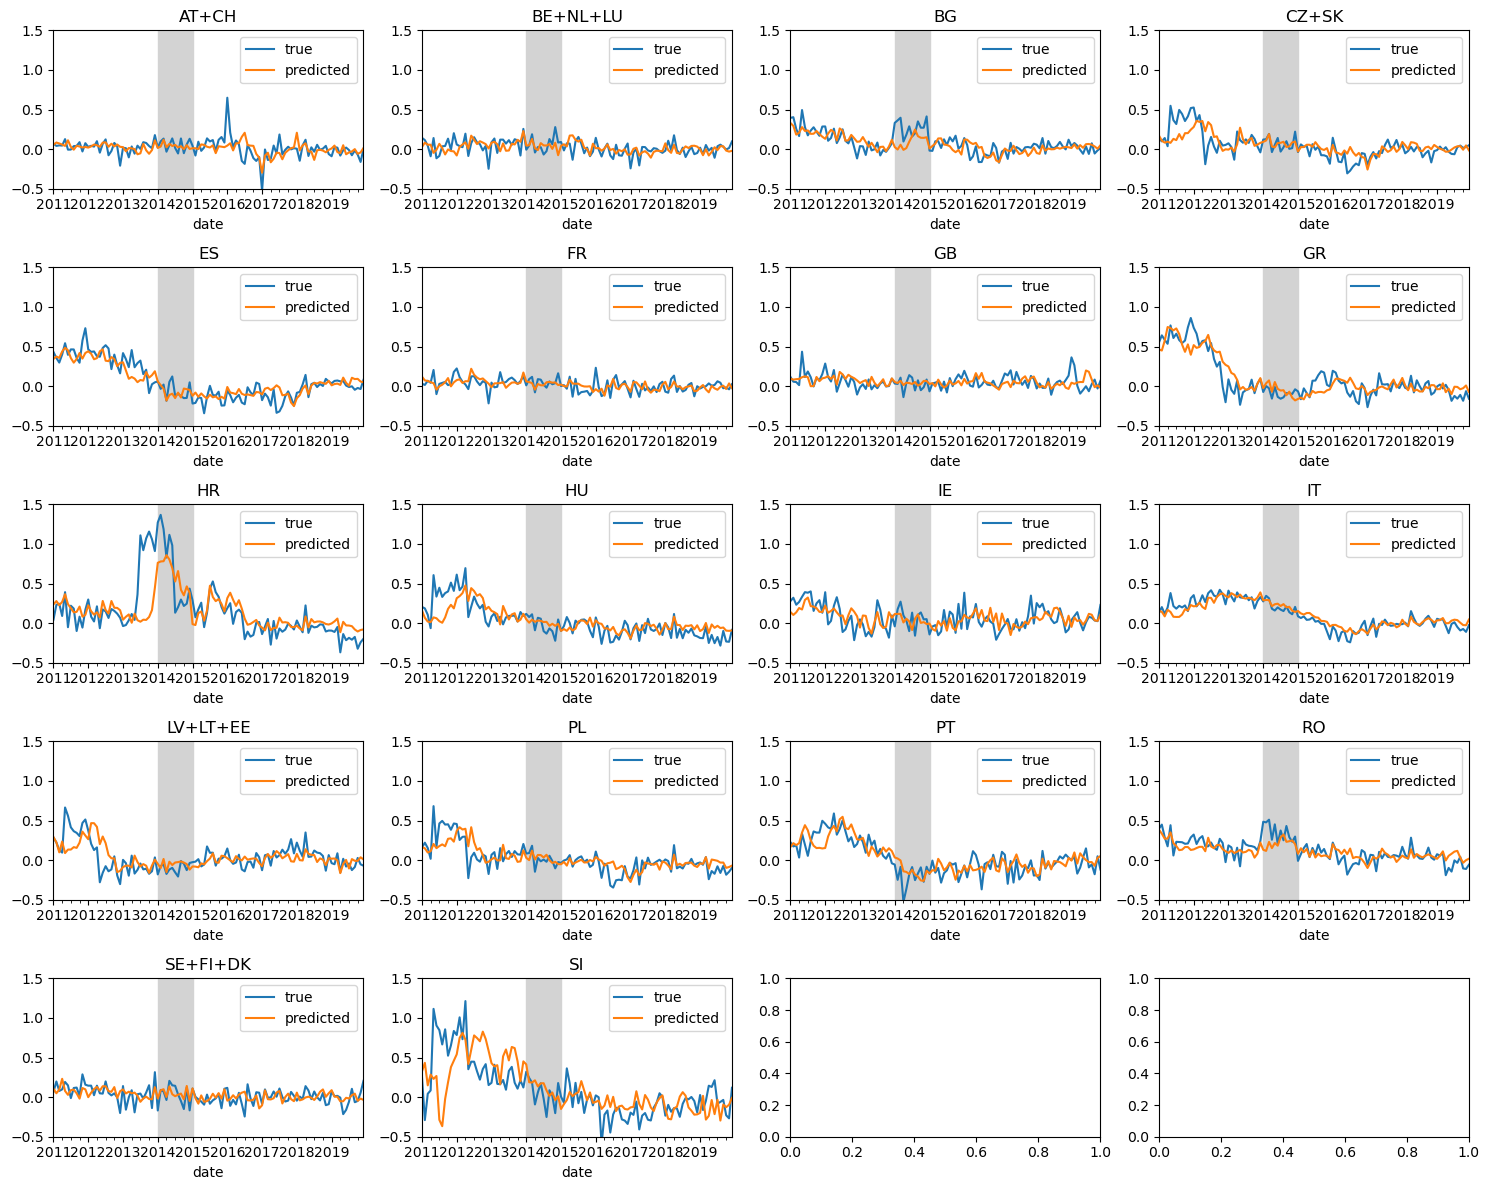

In [49]:
i = -1
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


#### Plot prediction (without own lags)

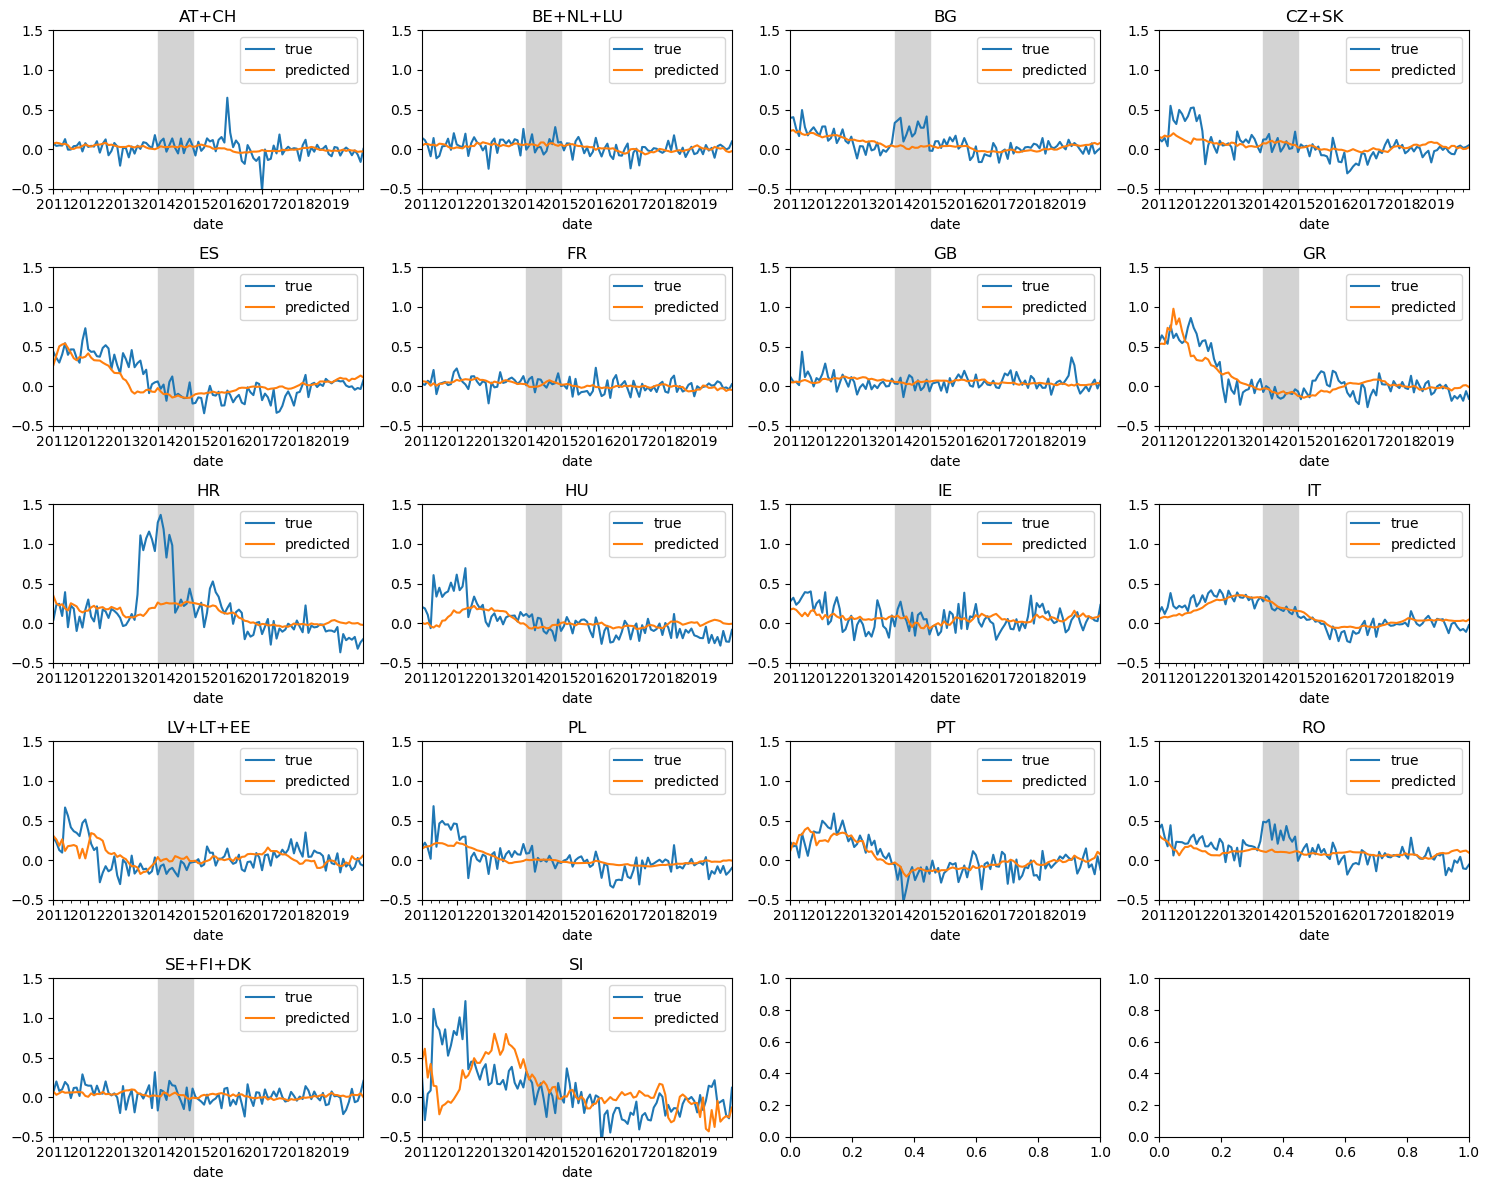

In [51]:
i = 2

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

### monthly frequency with 3m rolling mean

In [ ]:
### TRAINING

feature_combinations = [
    ["19"],
    ["value"],
    ["value", "19"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds = [], []

params = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__positive": [True, False],
}

panel_resampled = panel_comb.rolling("90D").mean()

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_resampled, columns=features, lags=[3, 6, 9, 12]
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_stackeds.append(train_stacked)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=linear_model.LinearRegression(),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        dummy_encoder="drop",
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [ ]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations)


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod              
                  mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem  
['19']            0.002   2.661e-04  1.006e-04    0.003    7.440e-04  2.812e-04  -0.085   0.033  0.012   -0.125   0.059  0.022           0.042          0.254  0.096     0.129    0.285  0.108
['value']         0.002   5.184e-04  1.959e-04    0.003    7.601e-04  2.873e-04  -0.062   0.016  0.006   -0.088   0.030  0.011           0.465          0.119  0.045     0.516    0.168  0.063
['value', '19']   0.003   2.966e-04  1.121e-04    0.003    7.780e-04  2.941e-04  -0.062   0.015  0.006   -0.088   0.030  0.011           0.472          0.105  0.040     0.524    0.159  0.060

In [ ]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations)

,mae,rmse,explained_variance,r2_mod
['19'],-0.125,-0.211,0.308,0.260
['value'],-0.073,-0.112,0.762,0.791
"['value', '19']",-0.072,-0.110,0.772,0.800


### All Keywords

#### all features

In [ ]:
params = (
    {
        "elasticnet__alpha": [1.0, 0.2, 0.1, 0.5, 0.01],
        "elasticnet__l1_ratio": [0.4, 0.45, 0.5, 0.55, 0.6],
        "elasticnet__fit_intercept": [True, False],
        "elasticnet__positive": [True, False],
    },
)

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, lags=[1, 2, 3, 4])
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=linear_model.ElasticNet(),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    dummy_encoder="drop",
    params=params,
    scoring=eumf_eval.scorer_rmse,
)

cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked)


In [ ]:
eumf_eval.agg_cv_scores(cv_score)

,mean,std,sem
fit_time,0.010,1.277e-03,4.827e-04
score_time,0.007,8.218e-04,3.106e-04
test_mae,-0.061,1.122e-02,4.239e-03
test_rmse,-0.090,2.972e-02,1.123e-02
test_explained_variance,0.418,1.306e-01,4.936e-02
test_r2_mod,0.482,1.747e-01,6.602e-02


In [ ]:
test_score

mae                  -0.081
rmse                 -0.127
explained_variance    0.694
r2_mod                0.725
dtype: float64

##### non-zero coefficients

In [ ]:
reg = tuner.best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
coefs = pd.Series(reg.steps[-1][1].coef_, index=features_names_out).sort_values(
    ascending=False
)
coefs[coefs > 0.0]



value_1     1.048e-01
unempl_1    8.961e-03
21_1        7.873e-03
28_2        5.562e-03
unempl_2    4.367e-03
48_2        3.197e-03
19_1        2.352e-03
26_2        2.169e-03
115_3       2.013e-03
24_1        1.684e-03
unempl_4    1.088e-03
21_3        1.051e-03
59_1        9.253e-04
58_2        8.861e-04
21_4        6.115e-04
54_1        6.015e-04
115_2       8.972e-05
dtype: float64

#### all except own lag

In [ ]:
params = (
    {
        "elasticnet__alpha": [1.0, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01],
        "elasticnet__l1_ratio": [0.35, 0.38, 0.4, 0.42, 0.45, 0.5, 0.55, 0.6],
        "elasticnet__fit_intercept": [True, False],
        "elasticnet__positive": [True, False],
    },
)

columns = [
    c for c in panel_comb_3m_macro.columns.get_level_values(0).unique() if c != "value"
]

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro, lags=[1, 2, 3, 4], columns=columns
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=linear_model.ElasticNet(),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    dummy_encoder="drop",
    params=params,
    scoring=eumf_eval.scorer_rmse,
)

cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked)

tuner.best_params_


{'elasticnet__alpha': 0.03,
 'elasticnet__fit_intercept': False,
 'elasticnet__l1_ratio': 0.4,
 'elasticnet__positive': True}

In [ ]:
eumf_eval.agg_cv_scores(cv_score)

,mean,std,sem
fit_time,0.011,6.452e-04,2.439e-04
score_time,0.007,8.596e-04,3.249e-04
test_mae,-0.084,2.331e-02,8.812e-03
test_rmse,-0.122,4.870e-02,1.841e-02
test_explained_variance,0.066,1.453e-01,5.491e-02
test_r2_mod,0.092,3.739e-01,1.413e-01


In [ ]:
test_score

mae                  -0.119
rmse                 -0.208
explained_variance    0.237
r2_mod                0.269
dtype: float64

##### non-zero coefficients

In [ ]:
reg = tuner.best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
coefs = pd.Series(reg.steps[-1][1].coef_, index=features_names_out).sort_values(
    ascending=False
)
coefs[coefs > 0.0]



19_1        0.028
unempl_2    0.019
unempl_1    0.016
19_2        0.015
unempl_4    0.013
28_3        0.007
28_4        0.006
24_1        0.005
unempl_3    0.005
28_2        0.004
19_3        0.004
dtype: float64